In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
import matplotsoccer as mps
import atomic.vaep as vaep

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions-one-action.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore,\
    pd.HDFStore(predictions_h5) as predstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        p = predstore[f"game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        assert len(a) == len(p)
        a = pd.concat([a,p],axis=1)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]
actions = pd.concat([actions,vaep.value(actions,actions.scores,actions.concedes)],axis=1)

380it [00:14, 26.57it/s]


In [10]:
# Make a nice action subset
import pattern.action as pat

a = actions[200000:400000].fillna(0)
a["type_name"] = "all_actions"
#a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
#a["x"] = a.x.mask(a.type_name=="goal",105)
#a["y"] = a.y.mask(a.type_name=="goal",32.5)
#a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
#a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)
len(a)

200000

In [62]:
import pattern.action as pat

cols = ["x","y",
        "dx","dy",
       ]
type_names = set(a.type_name)

nc = {"pass":50,"receival":50,"interception":50,"dribble": 50, "corner": 4}

gmme = pat.GMMEnsemble(cols, {k: mix.GaussianMixture(nc.get(k,20)) for k in type_names})
gmme.fit(a,verbose=True)

learning 20 all_actions components from 200000 actions
bad models: []


In [11]:
#list((m.n_components,s) for t,m,s in normcandidates if t=="shot")
ov = a.groupby("type_name")[["concedes","scores"]].sum()
ov["combined"] = abs(ov.scores-ov.concedes)
ov = dict(ov.combined)
ov

{'bad_touch': 5.5465061200084165,
 'clearance': 17.506364066084643,
 'corner': 18.109284892292635,
 'cross': 47.39473717088913,
 'dribble': 371.7690714786986,
 'foul': 24.31433117546476,
 'freekick': 9.586426928668516,
 'goal': 180.87652141788567,
 'goalkick': 0.4247314909371198,
 'interception': 17.726470576802967,
 'keeper_catch': 16.644079430945567,
 'offside': 1.4904959678970044,
 'out': 1.286953321974579,
 'owngoal': 1.5932284324953798,
 'pass': 259.1947378386867,
 'receival': 348.17318946287924,
 'red_card': 0.025341430824482813,
 'shot': 193.2428371416172,
 'shot_penalty': 11.879851936420891,
 'tackle': 0.1735326512134634,
 'take_on': 28.120948155563383,
 'throw_in': 4.056572209083242,
 'yellow_card': 2.475093361514155}

all_actions 20 200000


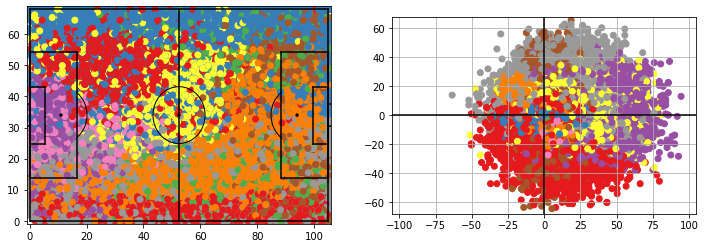

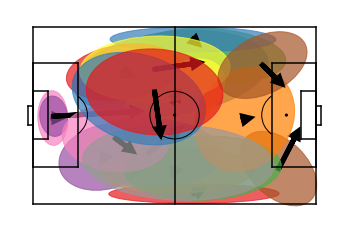

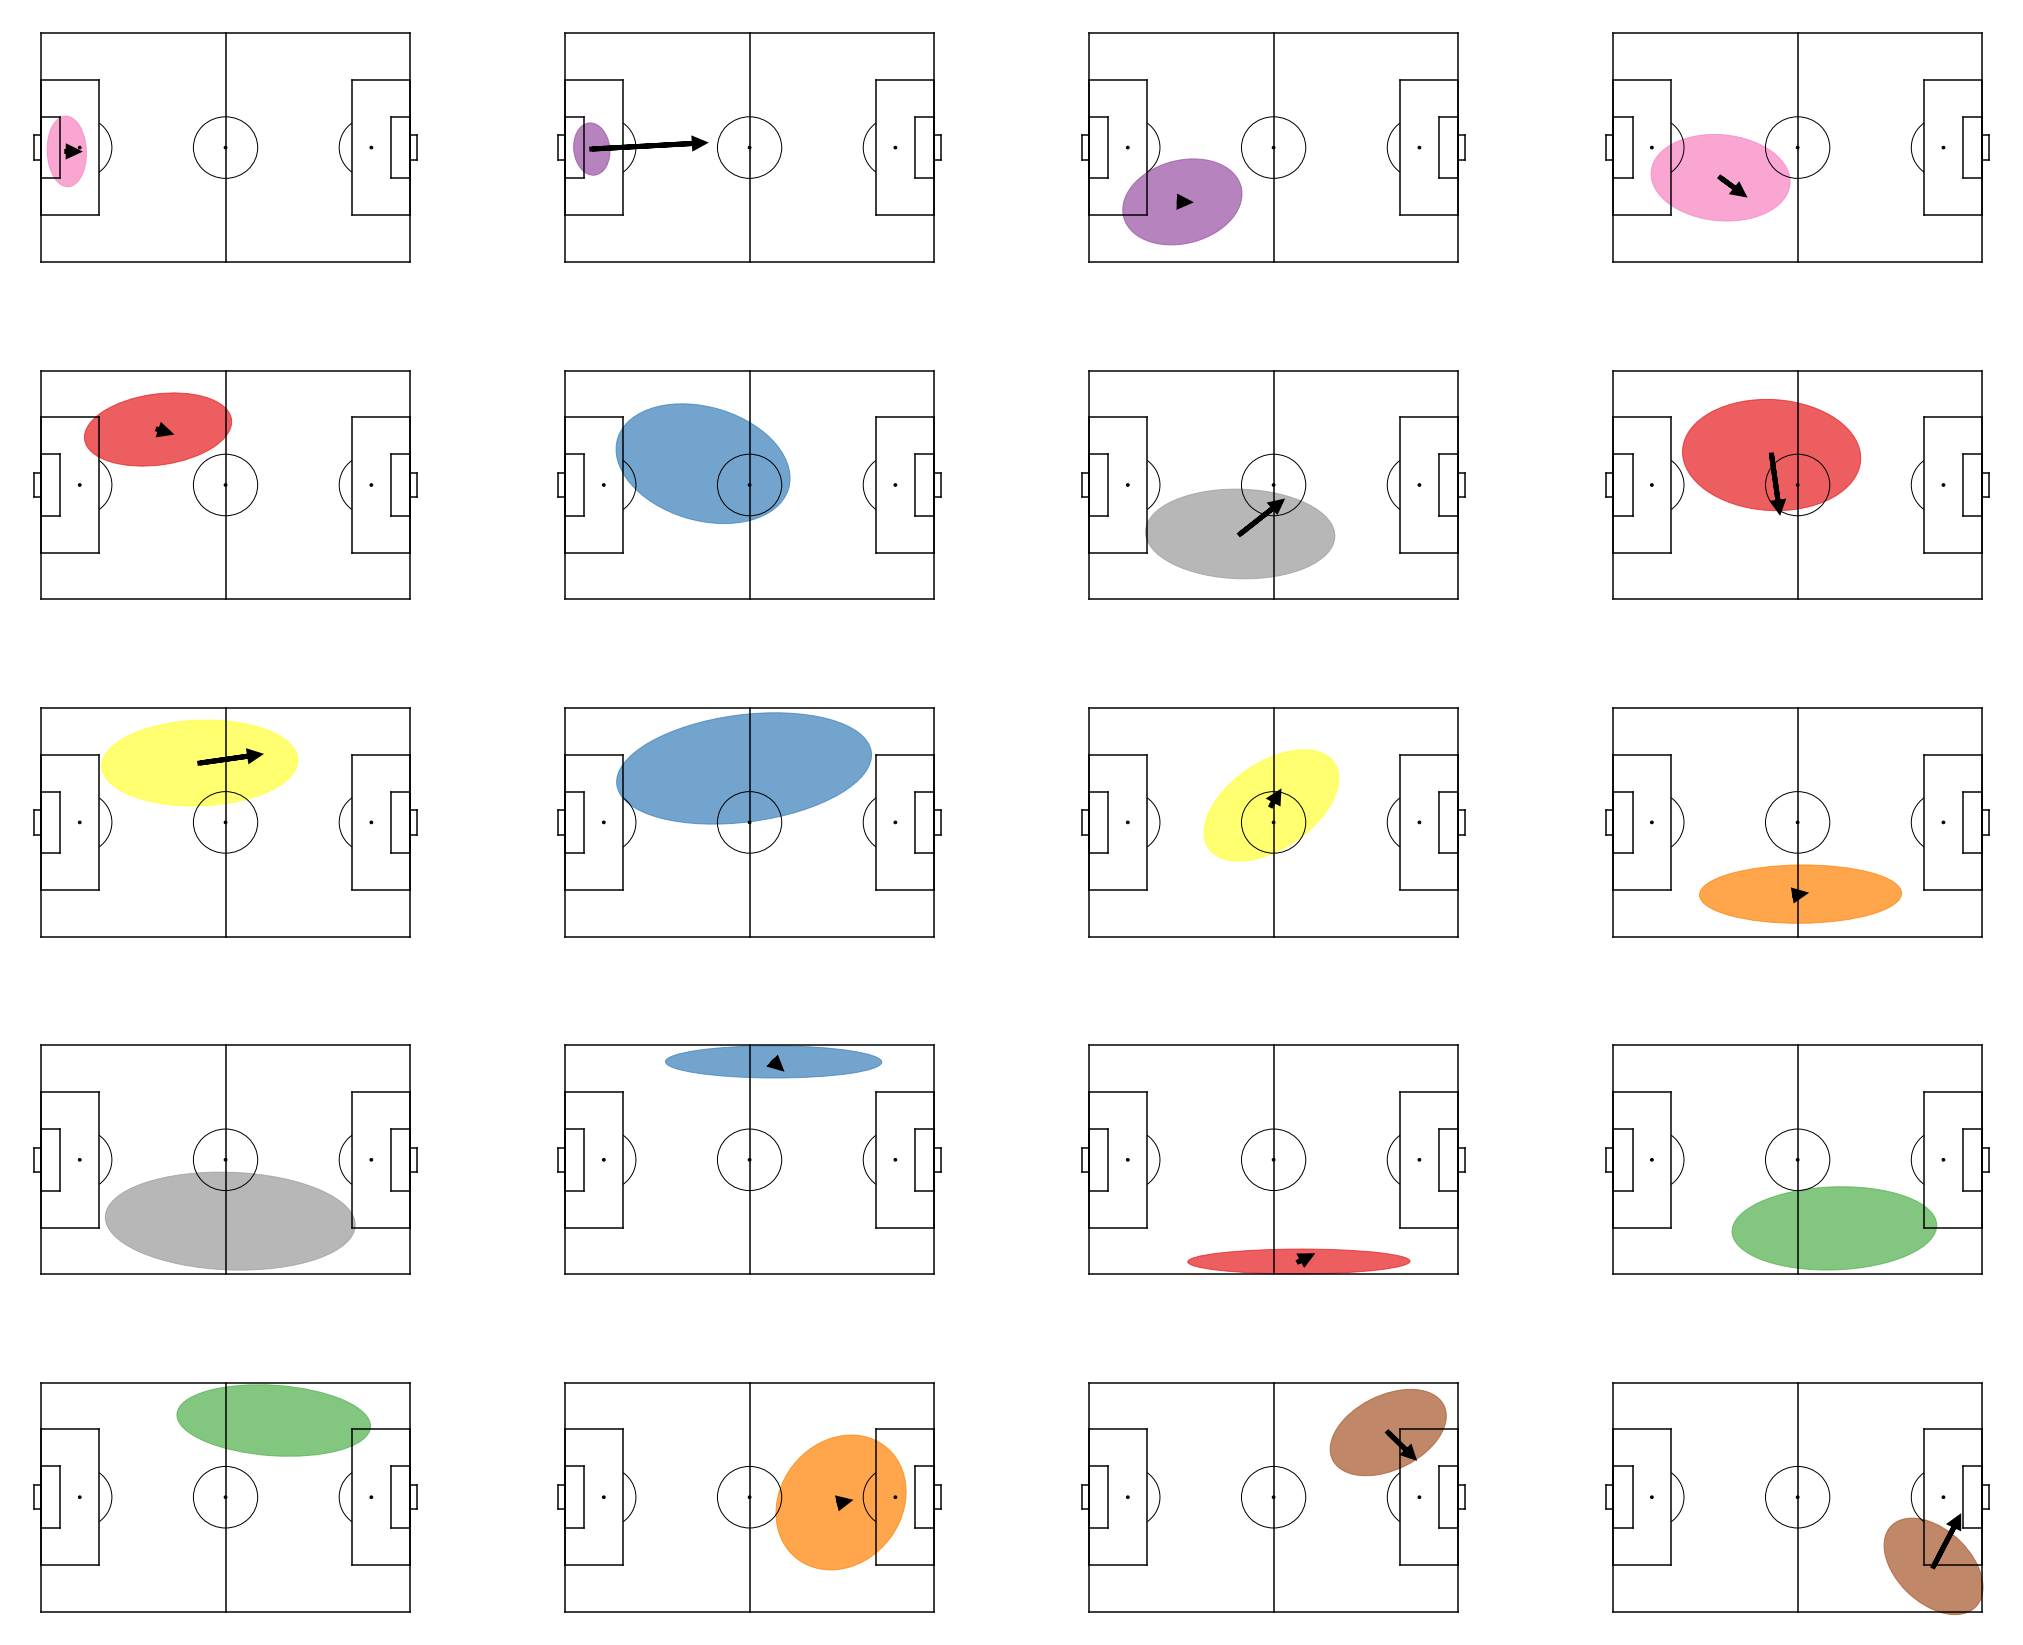

In [71]:
import pattern.vis as vis
for k, gmm in sorted(list(gmme.models.items())):
    df = a[a.type_name == k]
    print(k,gmm.n_components,len(df))
    #vis.plot_gmm(gmm)
    vis.plot_gmm_actions(gmm,df,gmme.cols,samplefn="max")

    ax = mps.field(show=False)
    for i in range(gmm.n_components):
        vis.plot_component_w_arrow(gmm,i,ax=ax,color = vis.colors[i % len(vis.colors)],show=False)
    plt.show()
    vis.plot_components_arrows(gmm)

In [28]:
test = np.array([[0.1,0.9,0],[0.9,0.1,0],[0,0,1]])
for i in range(12):
    test = np.dot(test,test.T)
test

array([[0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0. , 0. , 1. ]])

In [64]:
%%time
import tqdm
transes = []

def uncouple_probabilities(probs,left_to_right):
    home = probs.values.copy()
    home[~left_to_right] = 0
    away = probs.values.copy()
    away[left_to_right] = 0
    uc_probs = np.concatenate([home,away],axis=1)
    return pd.DataFrame(uc_probs,columns = list(probs.columns) + list (t + "_opp" for t in probs.columns))

for game_id, df in tqdm.tqdm(#actions.fillna(0)
                             a.groupby("game_id")):
    probas = gmme.predict_proba(df)
    ucprobas = uncouple_probabilities(probas,df.is_home.values)
    prev = ucprobas.values[:-1]
    nex = ucprobas.values[1:]
    trans = np.dot(prev.T,nex)
    transes.append(trans)
trans = np.sum(transes,axis=0)

100%|██████████| 65/65 [00:00<00:00, 89.96it/s]

CPU times: user 1.15 s, sys: 284 ms, total: 1.43 s
Wall time: 737 ms


In [45]:
#gmme.predict_proba(df)
test = np.array([[0.1,0.9,0],[0.9,0.1,0],[0,0,1]])
for i in range(12):
    trans = np.dot(trans.T,trans,np.dot(trans,trans.T)
    trans = np.dot(trans.T,trans)
test

array([[3.86248883e+03, 1.04955393e+04, 2.57364291e+02, 1.31409432e+03,
        4.50203898e+00, 2.08968757e+03, 5.03878995e+00, 1.91061812e+01],
       [9.63616640e+03, 4.96199920e+03, 1.09740886e+04, 1.27567428e+04,
        1.07567502e+03, 5.05999921e+02, 3.05373694e+02, 2.17395104e+03],
       [2.87598234e+03, 1.85042568e+03, 5.08601097e+02, 6.22217712e+03,
        1.21284725e+01, 9.17675502e+02, 1.90384799e+01, 4.10372104e+01],
       [6.08875000e+02, 1.65980331e+04, 4.00897639e+02, 4.85152432e+03,
        1.48556559e+01, 4.84463639e+03, 5.98290467e+00, 3.53111337e+01],
       [2.14211968e+00, 2.00499399e+03, 3.65000597e+00, 1.90115773e+01,
        3.82356020e+03, 1.06905369e+04, 2.57447388e+02, 1.29517221e+03],
       [1.04127409e+03, 5.13999919e+02, 2.76006797e+02, 2.08571888e+03,
        9.61840816e+03, 4.81199922e+03, 1.10301207e+04, 1.26414689e+04],
       [1.55413801e+01, 9.97256477e+02, 1.48746883e+01, 5.37289252e+01,
        2.94059063e+03, 1.91245653e+03, 5.50905178e+02, 6.

In [32]:

#transes
probas = gmme.predict_proba(df)
#uncouple_probabilities(probas,df.is_home.values)
ori = probas.values.copy()
ori[df.is_home.values] = 0
#ori.shape
np.concatenate([ori,ori],axis=1).shape

(2948, 8)

In [42]:
%%time
ucprobas = pat.uncouple_probabilities(probas,actions.is_home.values)
ucprobas
ucprobas.sum()

MemoryError: Unable to allocate array with shape (701, 1188670) and data type float64

In [83]:
print(probas.memory_usage().sum() / 1000 / 1000 / 1000)
prev = probas.values[:-1]
nex = probas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)

3.5374820479999998
(1188669, 372)


In [85]:
trans = trans + 0.1

In [35]:
%%yim
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
#plt.matshow(trans)
#plt.colorbar()
#plt.show()
trans = trans + 0.1
#trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
#trans.sum()
#ori_trans = trans

(199999, 2006)


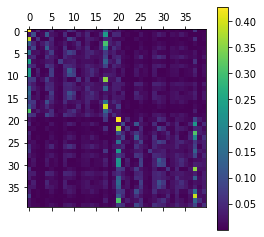

In [65]:
sim = trans.copy() 

for i in range(1):
    forwardtrans = sim.copy()
    for i in range(len(forwardtrans[0])):
         forwardtrans[i,:] /= forwardtrans[i,:].sum()

    backwardtrans = sim.T.copy()
    for i in range(len(backwardtrans[0])):
         backwardtrans[i,:] /= backwardtrans[i,:].sum()
    forwardtrans.sum(),backwardtrans.sum()
    sim = np.dot(forwardtrans,backwardtrans)# + np.dot(backwardtrans,forwardtrans))/2
    #print(sim.sum())

plt.matshow(sim)
plt.colorbar()
plt.show()

In [58]:
def get_name(i):
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    return "_".join([ty,str(k),str(is_opp)])

0
Counter({('all_actions', False): 7})


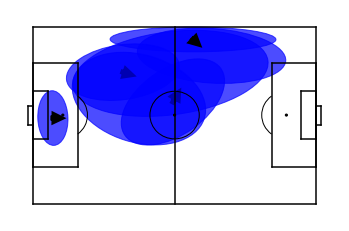

1
Counter({('all_actions', True): 8})


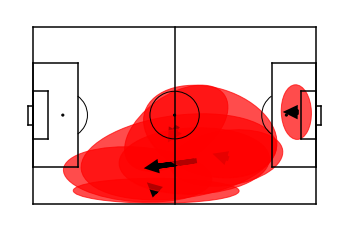

2
Counter({('all_actions', False): 6})


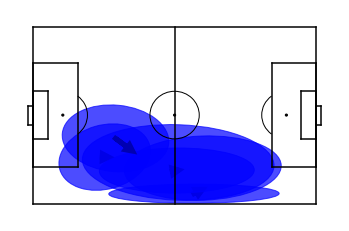

3
Counter({('all_actions', True): 6})


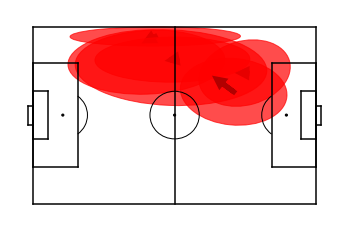

4
Counter({('all_actions', False): 7, ('all_actions', True): 6})


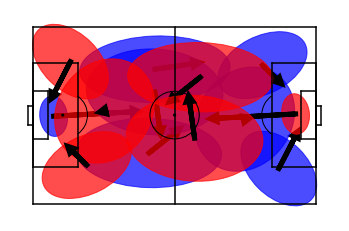

In [66]:
from collections import Counter
from sklearn.cluster import SpectralClustering

nc = 5

clustering = SpectralClustering(affinity="precomputed",n_clusters=nc).fit((sim + sim.T)/2)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

0
Counter({('pass', False): 9, ('cross', False): 9})


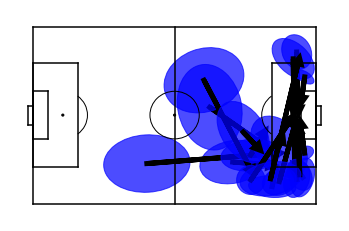

1
Counter({('shot', False): 5, ('shot_penalty', False): 2})


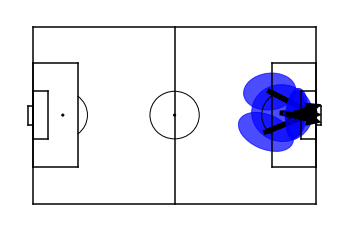

2
Counter({('dribble', False): 33})


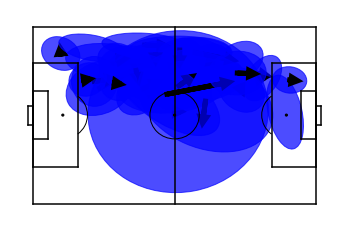

3
Counter({('interception', False): 12, ('bad_touch', False): 10, ('keeper_catch', False): 10, ('take_on', False): 10, ('corner', False): 10, ('freekick', False): 10, ('tackle', False): 10, ('yellow_card', False): 10, ('foul', False): 10, ('offside', False): 9, ('shot_penalty', False): 8, ('shot', False): 5, ('goal', False): 3, ('owngoal', False): 1, ('dribble', False): 1, ('red_card', False): 1})


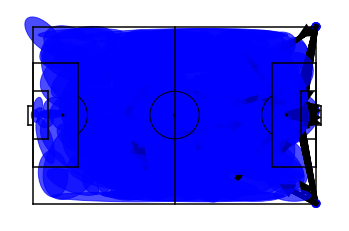

4
Counter({('out', False): 1})


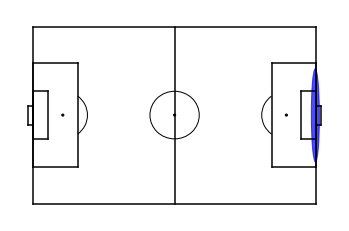

5
Counter({('pass', False): 20})


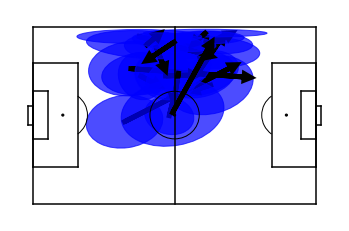

6
Counter({('goal', False): 7, ('out', False): 1})


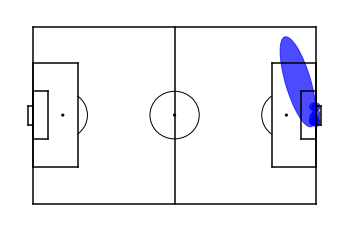

7
Counter({('receival', False): 6, ('out', False): 2})


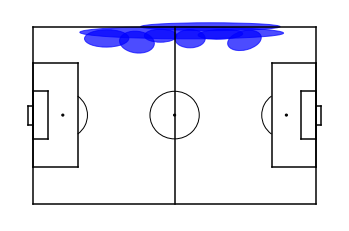

8
Counter({('out', False): 2, ('interception', False): 1})


../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


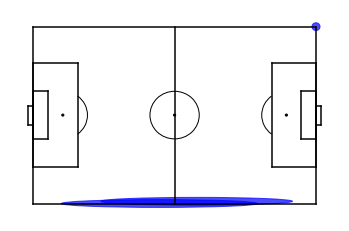

9
Counter({('dribble', False): 15})


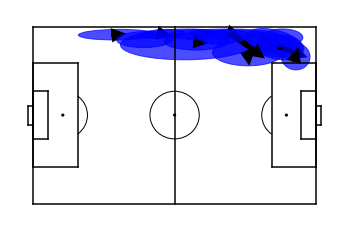

10
Counter({('dribble', False): 14})


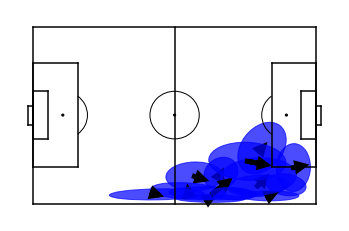

11
Counter({('receival', False): 8, ('out', False): 1})


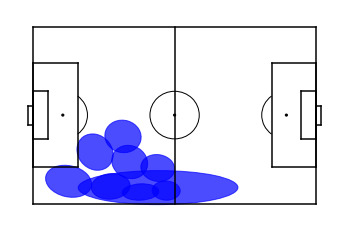

12
Counter({('interception', False): 14, ('receival', False): 8})


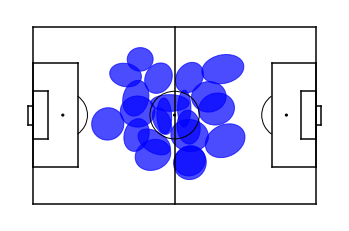

13
Counter({('dribble', False): 30})


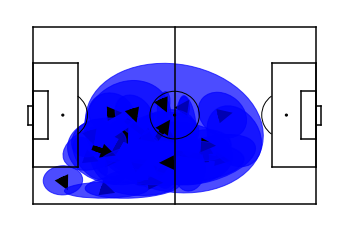

14
Counter({('goalkick', False): 10})


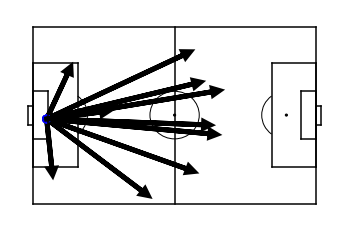

15
Counter({('interception', False): 5, ('receival', False): 1})


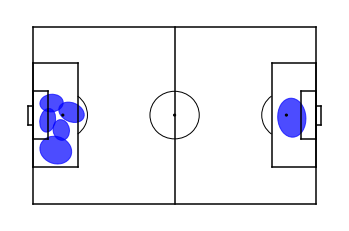

16
Counter({('interception', False): 8, ('receival', False): 5, ('out', False): 1})


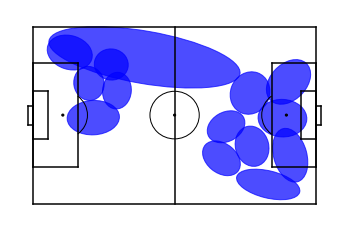

17
Counter({('pass', False): 12, ('throw_in', False): 5})


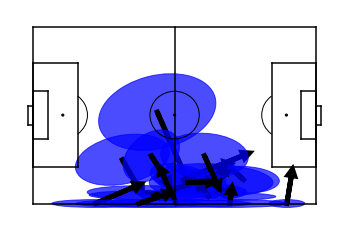

18
Counter({('clearance', False): 5, ('pass', False): 4})


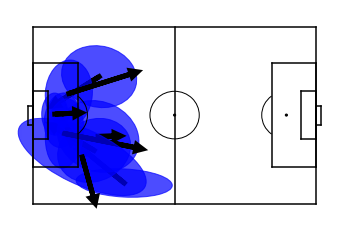

19
Counter({('interception', False): 7, ('receival', False): 4, ('out', False): 1, ('offside', False): 1})


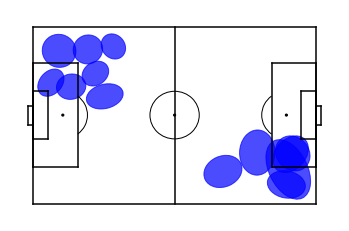

20
Counter({('receival', False): 6, ('interception', False): 2})


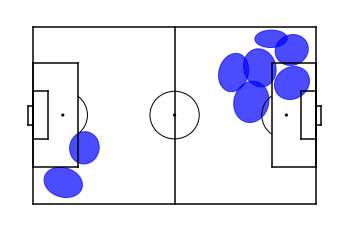

21
Counter({('pass', False): 12, ('cross', False): 1})


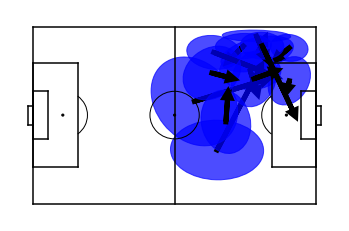

22
Counter({('pass', False): 27, ('clearance', False): 2})


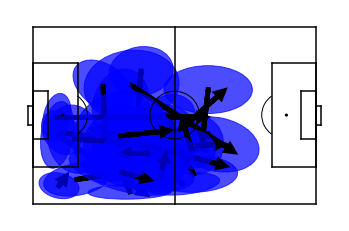

23
Counter({('receival', False): 3})


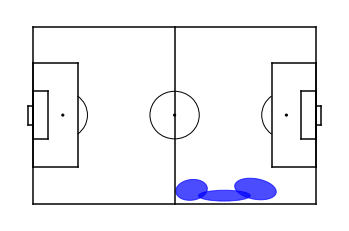

24
Counter({('receival', False): 6})


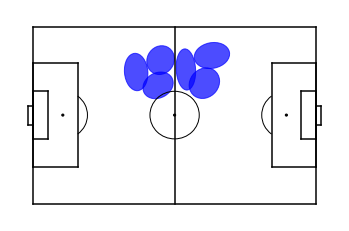

25
Counter({('dribble', False): 7})


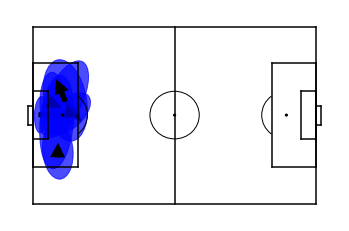

26
Counter({('pass', False): 16, ('clearance', False): 3})


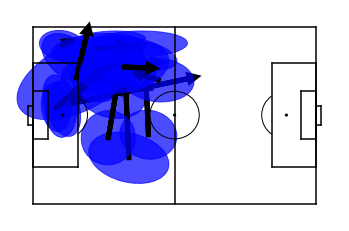

27
Counter({('interception', False): 1, ('out', False): 1})


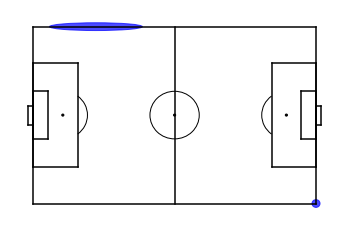

28
Counter({('throw_in', False): 5})


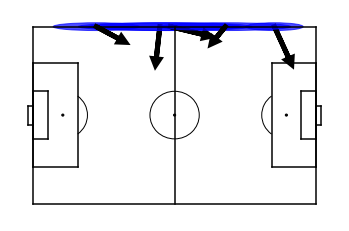

29
Counter({('receival', False): 3})


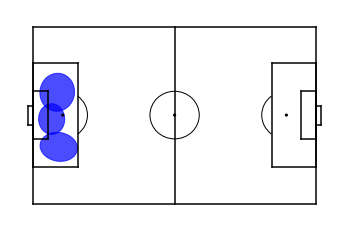

In [78]:
from collections import Counter
sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

from sklearn.cluster import KMeans

nc = 30

clus = KMeans(nc).fit(sim)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clus.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

0
Counter({('pass', False): 2})


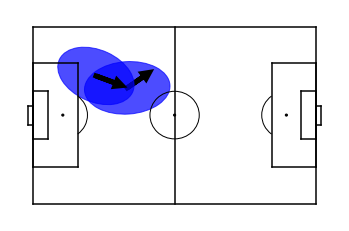

1
Counter({('pass', False): 3})


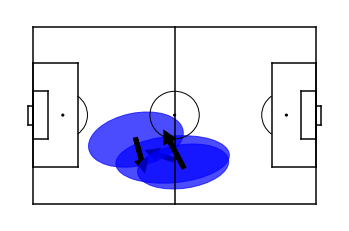

2
Counter({('pass', False): 4})


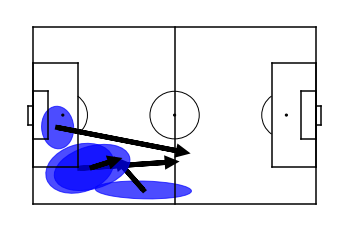

3
Counter({('pass', False): 2})


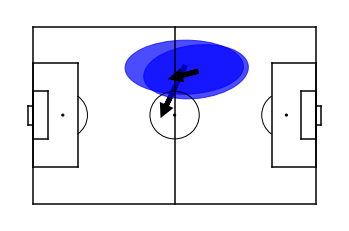

4
Counter({('interception', False): 2, ('receival', False): 1})


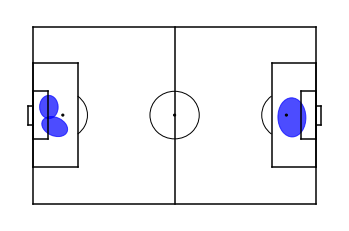

5


../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


Counter({('shot', False): 50, ('bad_touch', False): 50, ('keeper_catch', False): 50, ('take_on', False): 50, ('corner', False): 50, ('freekick', False): 50, ('tackle', False): 50, ('goal', False): 50, ('offside', False): 50, ('cross', False): 50, ('yellow_card', False): 50, ('foul', False): 50, ('throw_in', False): 50, ('goalkick', False): 50, ('clearance', False): 49, ('receival', False): 48, ('interception', False): 48, ('out', False): 48, ('dribble', False): 37, ('pass', False): 8, ('owngoal', False): 1, ('shot_penalty', False): 1, ('red_card', False): 1})


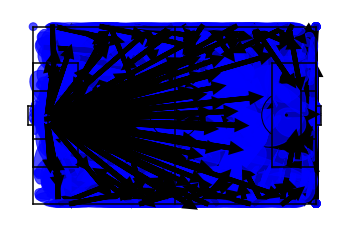

6
Counter({('dribble', False): 1})


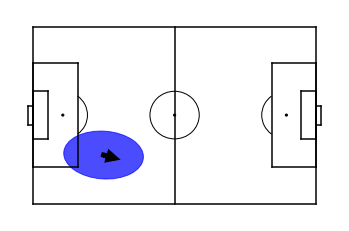

7
Counter({('dribble', False): 1})


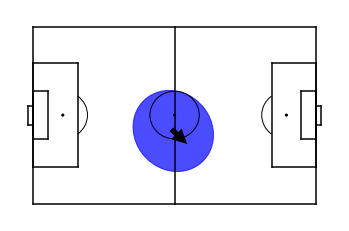

8
Counter({('pass', False): 1})


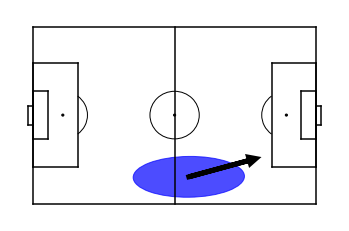

9
Counter({('dribble', False): 2})


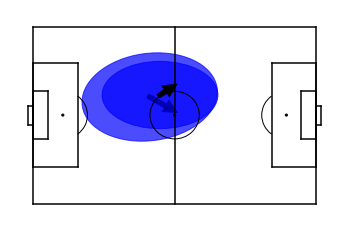

10
Counter({('pass', False): 2})


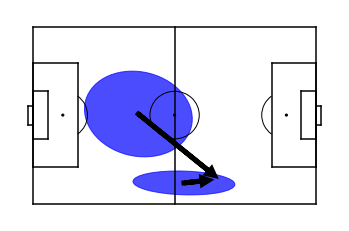

11
Counter({('dribble', False): 3})


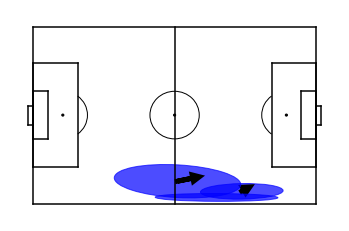

12
Counter({('pass', False): 1})


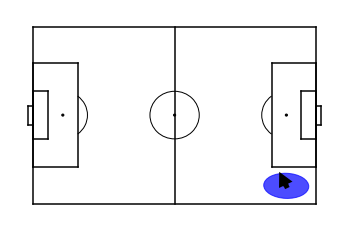

13
Counter({('dribble', False): 1})


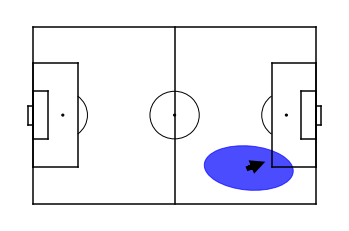

14
Counter({('out', False): 1})


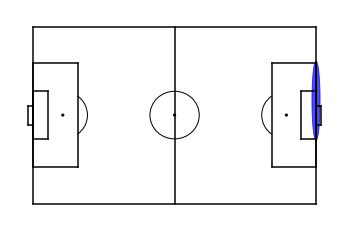

15
Counter({('dribble', False): 1})


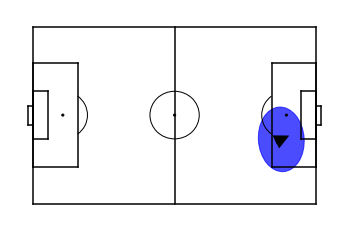

16
Counter({('pass', False): 1})


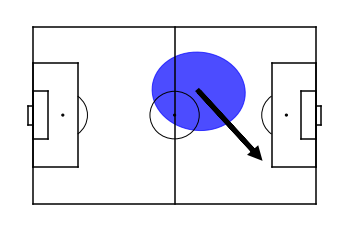

17
Counter({('pass', False): 1})


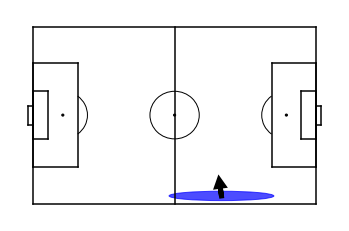

18
Counter({('pass', False): 1})


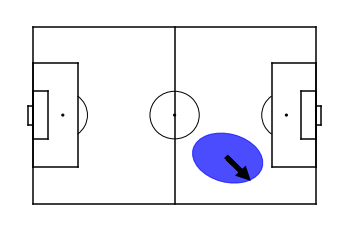

19
Counter({('dribble', False): 1})


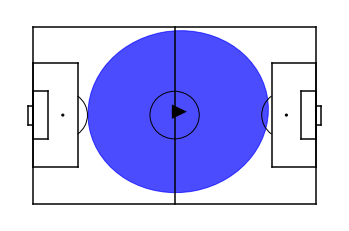

20
Counter({('dribble', False): 1})


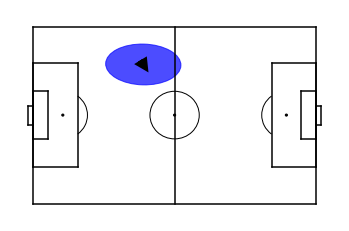

21
Counter({('out', False): 1})


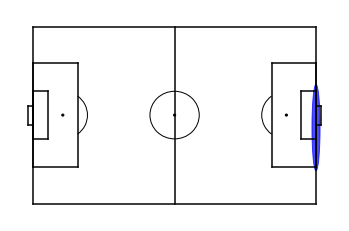

22
Counter({('dribble', False): 1})


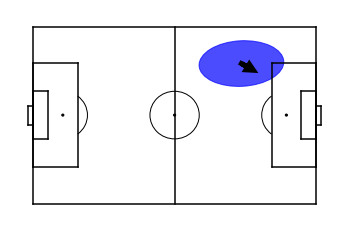

23
Counter({('pass', False): 1})


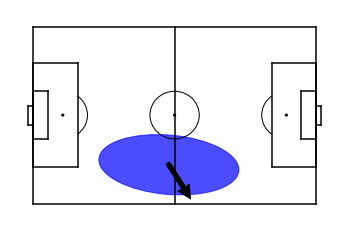

24
Counter({('clearance', False): 1})


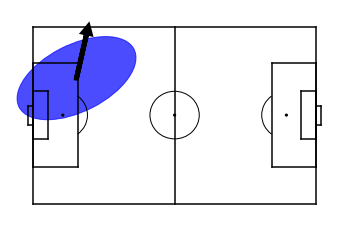

25
Counter({('pass', False): 1})


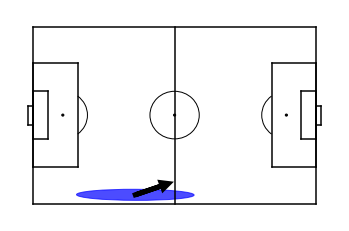

26
Counter({('pass', False): 1})


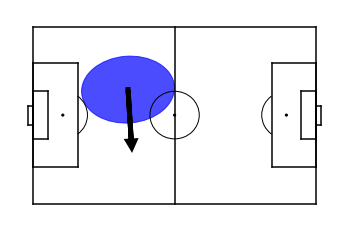

27
Counter({('pass', False): 1})


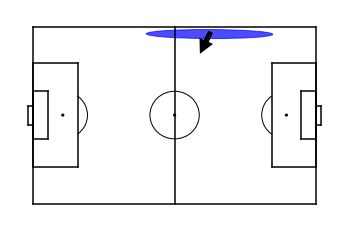

28
Counter({('pass', False): 1})


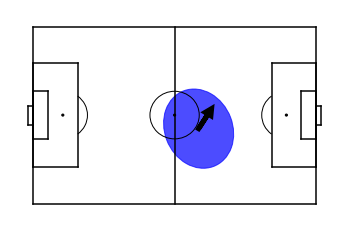

29
Counter({('pass', False): 1})


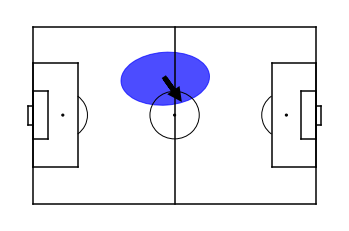

30
Counter({('pass', False): 1})


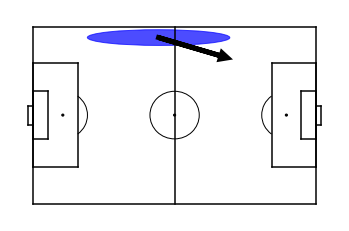

31
Counter({('pass', False): 1})


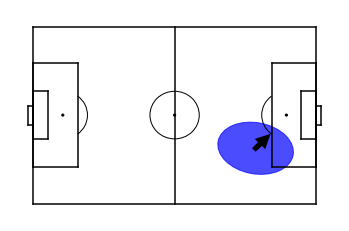

32
Counter({('dribble', False): 1})


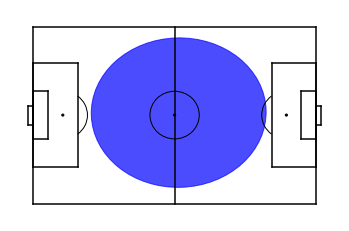

33
Counter({('pass', False): 1})


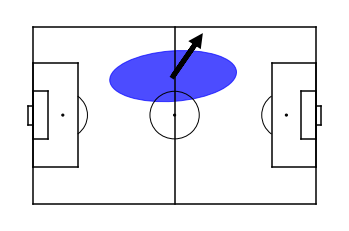

34
Counter({('pass', False): 1})


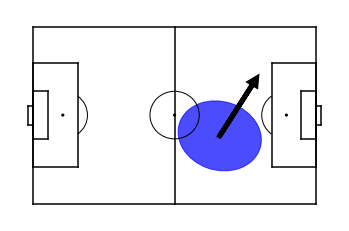

35
Counter({('pass', False): 1})


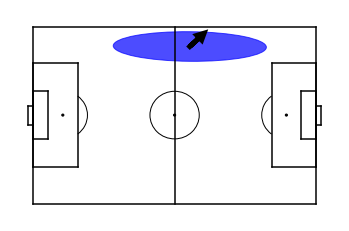

36
Counter({('pass', False): 1})


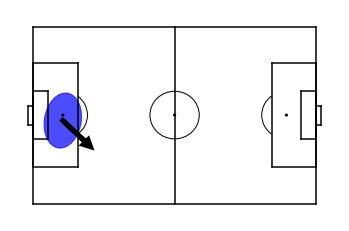

37
Counter({('pass', False): 1})


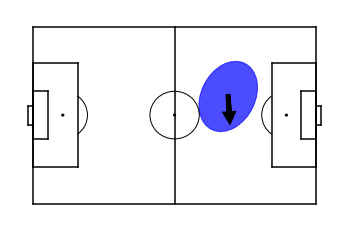

38
Counter({('pass', False): 1})


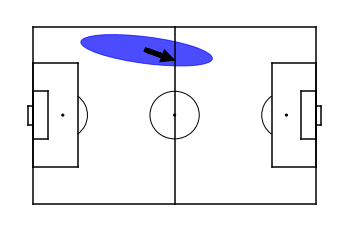

39
Counter({('pass', False): 1})


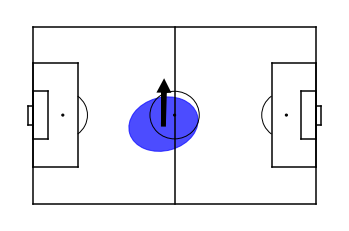

40
Counter({('pass', False): 1})


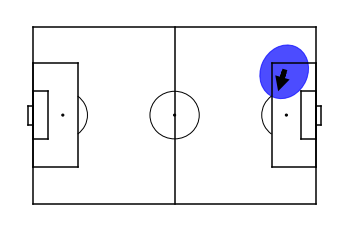

41
Counter({('pass', False): 1})


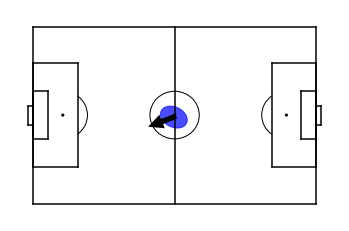

42
Counter({('pass', False): 1})


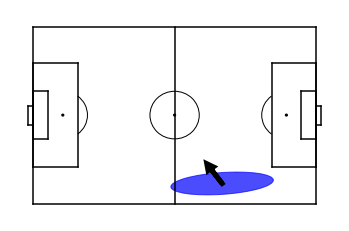

43
Counter({('pass', False): 1})


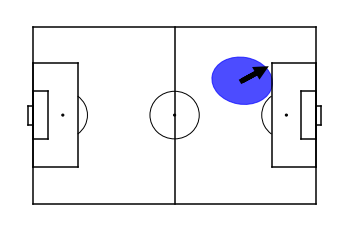

44
Counter({('pass', False): 1})


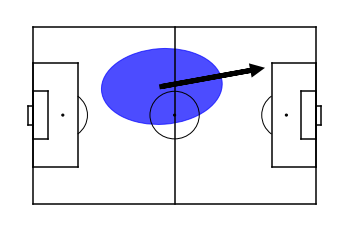

45
Counter({('pass', False): 1})


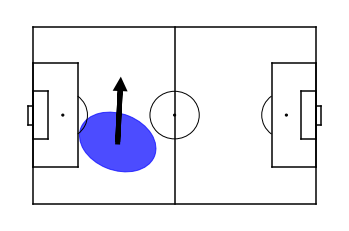

46
Counter({('receival', False): 1})


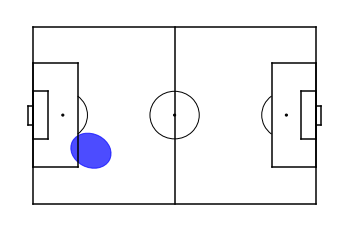

47
Counter({('pass', False): 1})


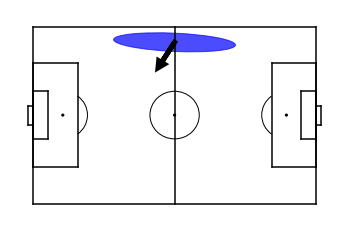

48
Counter({('pass', False): 1})


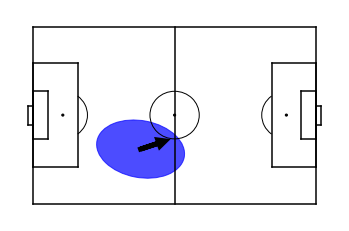

49
Counter({('pass', False): 1})


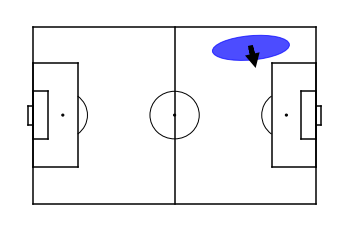

In [65]:
from collections import Counter


from sklearn.cluster import AgglomerativeClustering
nc = 50
clustering = AgglomerativeClustering(affinity="l1",linkage="single",n_clusters=nc).fit(sim.T)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

all_actions 4 False


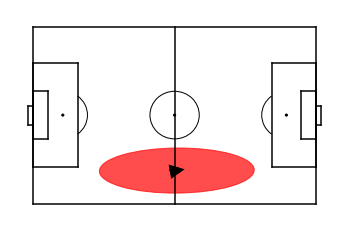

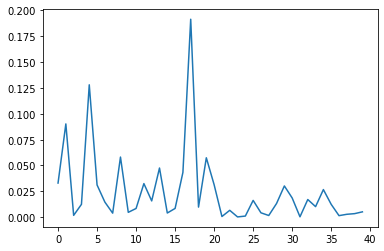

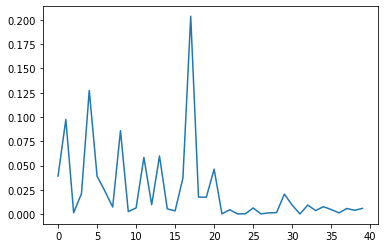

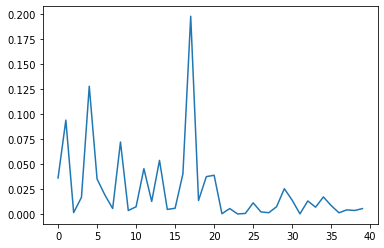

all_actions 17 False


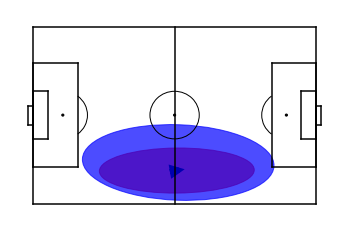

all_actions 4 False


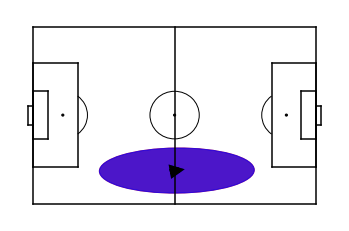

all_actions 1 False


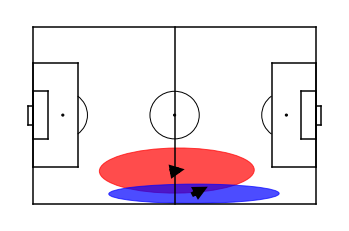

all_actions 8 False


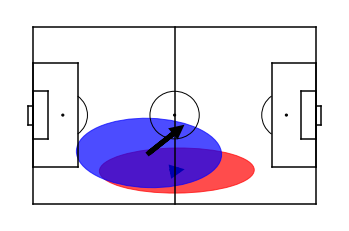

In [68]:
i = 4
ty,k = gmme._global_to_local(i % gmme.total_components())
is_opp = i > gmme.total_components() - 1
print(ty,k,is_opp)
vis.plot_component_w_arrow(gmme.models[ty],k,color="red",mirror=is_opp)

oldty,oldk,oldopp = ty,k,is_opp

v = np.zeros(gmme.total_components()*2)
v[i] = 1

forv = np.dot(np.dot(v,forwardtrans),backwardtrans)
plt.plot(forv)
plt.show()

backv = np.dot(np.dot(v,backwardtrans),forwardtrans)
plt.plot(backv)
plt.show()

newv = (forv + backv)/2
plt.plot(newv)
plt.show()

for j in np.argsort(newv)[::-1][:4]:
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    print(ty,k,is_opp)
    ax = vis.plot_component_w_arrow(gmme.models[oldty],oldk,color="red",mirror=oldopp,show=False)
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp)

In [ ]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

In [ ]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [ ]:
trans = delta_trans
trans = trans1

In [ ]:
trans.sum()

In [ ]:
plt.hist([p for p,i,j in probs])
plt.show()

In [ ]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break